## Compare how the elevation and tides are changing.

In [1]:
#General libraries DEM Bathymetry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#General libraries HEC-RAS
import h5py
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates

Cross Sections locations

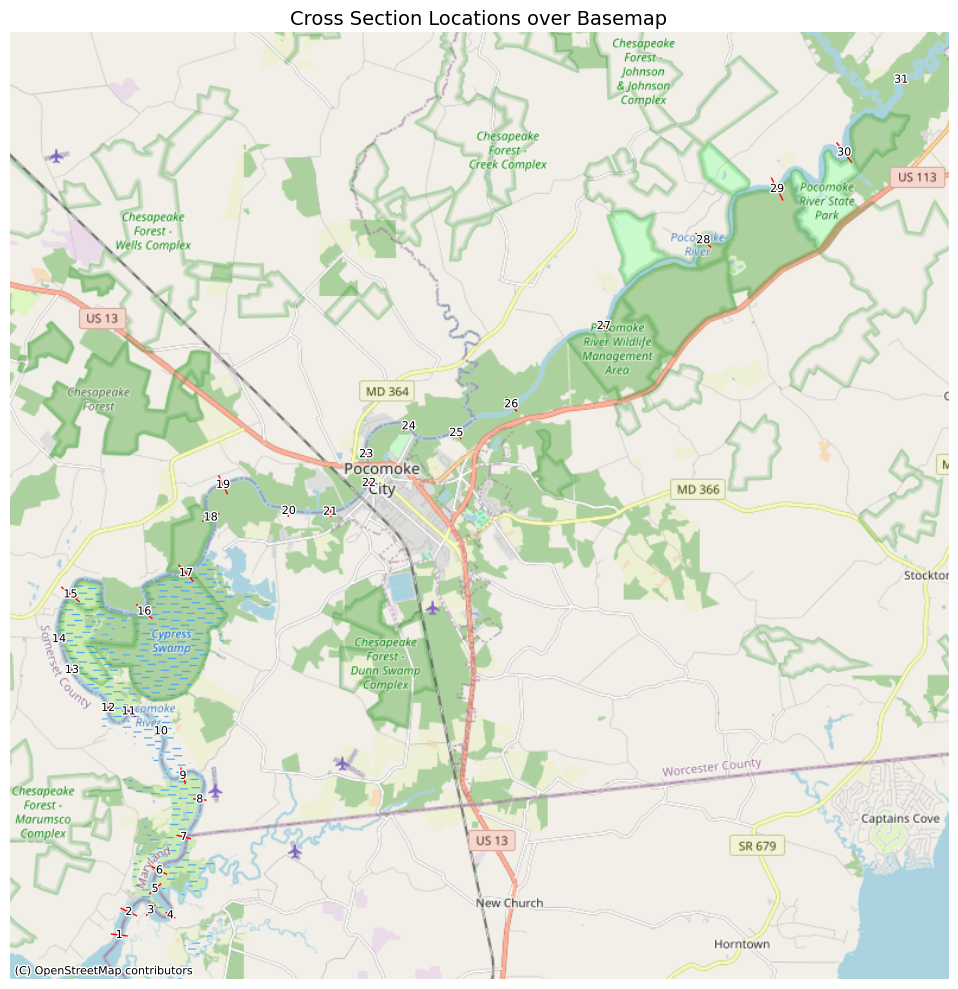

In [140]:
#Load your shapefile
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

#Convert to Web Mercator (required for basemap tiles)
lines_gdf = lines_gdf.to_crs(epsg=3857)

#Plot
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Carving channel 
NOTE:

    #BC data: total water level 
    #Gauge to compare: tides only 

#Boundary Condition data
USGS Starling


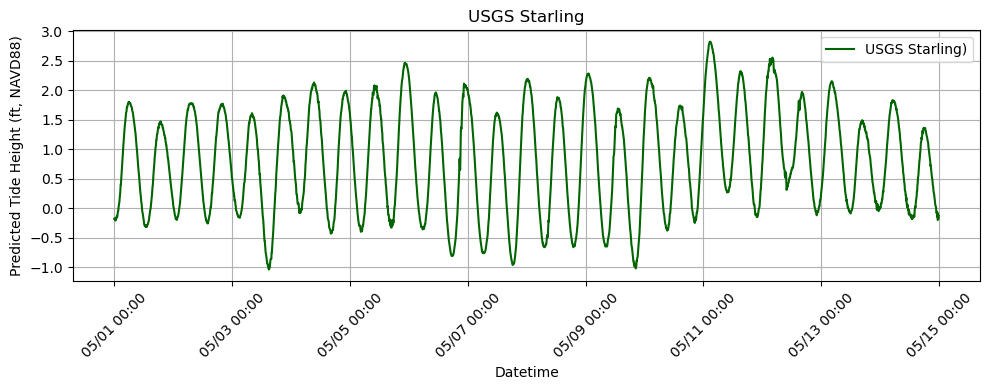

In [ ]:
#Gauge plot -#Starling gauge data - BC
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === File path ===
excel_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_gage.xlsx"

# === Load Sheet2
df = pd.read_excel(excel_path, sheet_name="Sheet2")

# === Clean column names and rename
df.columns = df.columns.str.strip().str.replace('\n', ' ', regex=True)
df.rename(columns={
    df.columns[0]: "Datetime",
    df.columns[1]: "Water Level (ft)",
}, inplace=True)

# === Plot with full datetime labels
plt.figure(figsize=(10, 4))
plt.plot(df["Datetime"], df["Water Level (ft)"], label="USGS Starling)", color='darkgreen')
plt.title("USGS Starling")
plt.xlabel("Datetime")
plt.ylabel("Predicted Tide Height (ft, NAVD88)")
plt.grid(True)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()

#Results using Shallow Water Equation for 31 cross sections

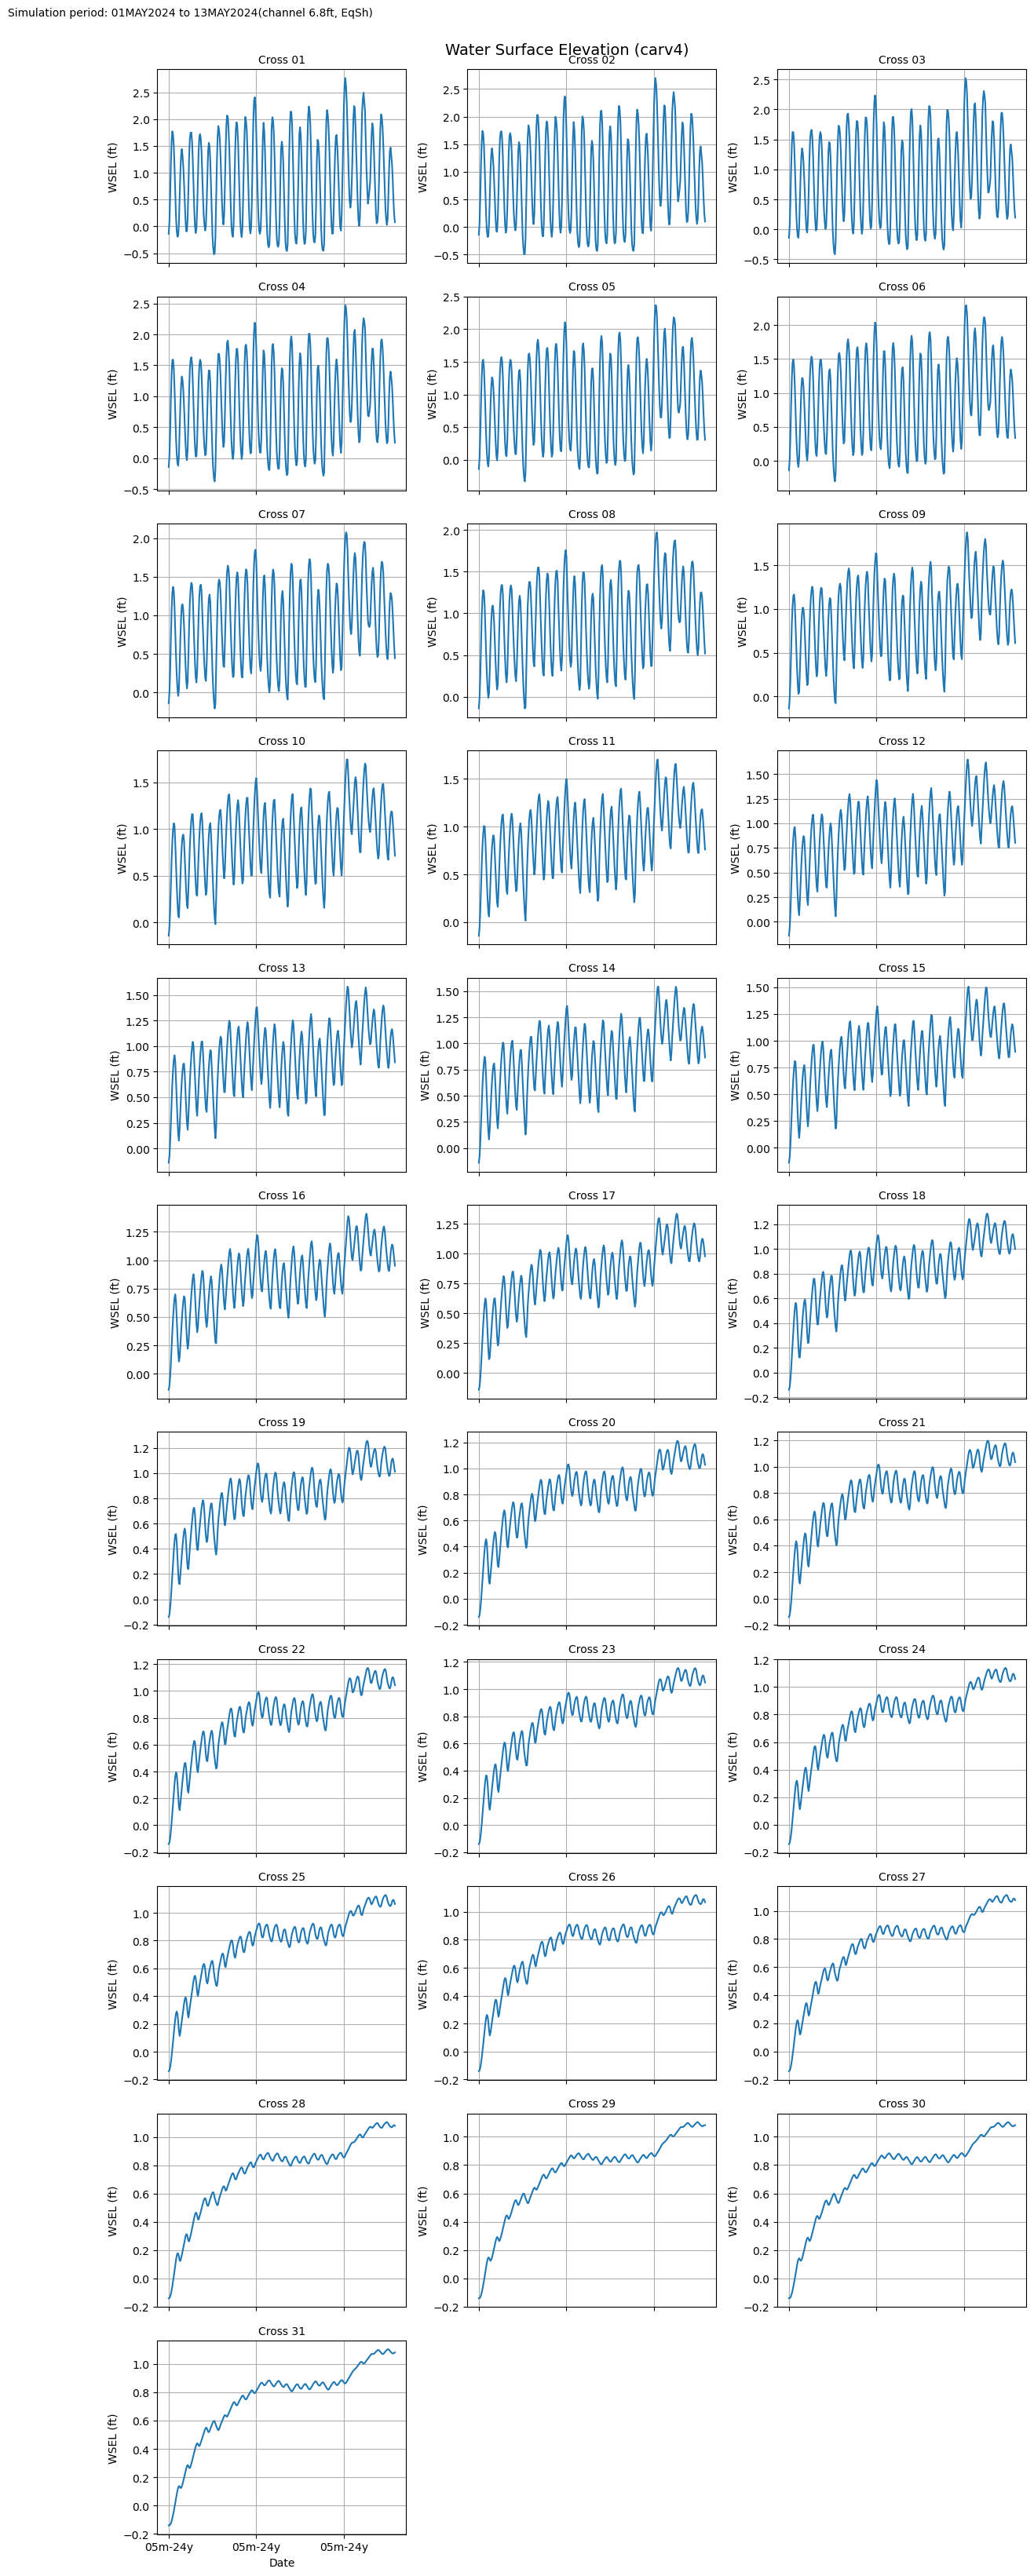

In [2]:
#Shallow Water Equation  (v5.p81)
##  Simulation (WSEL) at 31 Cross Sections (Carv4)
# FILES INPUTS
hdf_path = r'C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\HDF\v5.p81.hdf'
cell_ids = [628120, 627951, 627921, 628029, 627746, 627684, 627618, 627572, 627530, 627472, 627396, 627381, 635980, 635128, 636050, 635000, 634940, 627311, 634847, 636360, 694557, 845840, 827923, 814408, 660900, 647501, 634688, 634563, 636676, 627066, 634263]  # Replace with your actual cell IDs

# OPEN HDF FILE
with h5py.File(hdf_path, 'r') as f:
    # 1. Get time info
    time_minutes = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time'][:]
    start_str = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][0].decode()
    start_datetime = datetime.strptime(start_str, '%d%b%Y %H:%M:%S')
    time_index = [start_datetime + timedelta(minutes=float(t)) for t in time_minutes]

    # 2. Get full water surface matrix (time_steps x num_cells)
    ws_all = f['/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/VA20230620195713/Water Surface'][:]

    # 3. Get all cell minimum elevations
    z_all = f['/Geometry/2D Flow Areas/VA20230620195713/Cells Minimum Elevation'][:]

    # 4. Build WSEL  dataframe
    wsel_data = {}
    for cid in cell_ids:
        ws = ws_all[:, cid]
        wsel_data[f'Cell_{cid}'] = ws

# CREATE FINAL DATAFRAME
wsel_df = pd.DataFrame(wsel_data, index=pd.to_datetime(time_index))
wsel_df.index.name = 'Datetime'


#Mapping Cell ID → Cross Section Name
cell_to_cross = {
    628120: "Cross 01",
    627951: "Cross 02",
    627921: "Cross 03",
    628029: "Cross 04",
    627746: "Cross 05",
    627684: "Cross 06",
    627618: "Cross 07",
    627572: "Cross 08",
    627530: "Cross 09",
    627472: "Cross 10",
    627396: "Cross 11",
    627381: "Cross 12",
    635980: "Cross 13",
    635128: "Cross 14",
    636050: "Cross 15",
    635000: "Cross 16",
    634940: "Cross 17",
    627311: "Cross 18",
    634847: "Cross 19",
    636360: "Cross 20",
    694557: "Cross 21",
    845840: "Cross 22",
    827923: "Cross 23",
    814408: "Cross 24",
    660900: "Cross 25",
    647501: "Cross 26",
    634688: "Cross 27",
    634563: "Cross 28",
    636676: "Cross 29",
    627066: "Cross 30",
    634263: "Cross 31"
}

#Prepare Grid
num_cells = len(wsel_df.columns)
cols = 3  # Number of columns for subplots
rows = math.ceil(num_cells / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

#Plot with Custom Titles
for i, col in enumerate(wsel_df.columns):
    cell_id = int(col.replace("Cell_", ""))  # e.g., "Cell_627951" → 627951
    cross_name = cell_to_cross.get(cell_id, col)  # fallback to ID if not found

    ax = axes[i]
    ax.plot(wsel_df.index, wsel_df[col])
    ax.set_title(cross_name, fontsize=10)
    ax.set_ylabel("WSEL (ft)")
    ax.grid(True)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%mm-%yy'))

    if i >= (rows - 1) * cols:
        ax.set_xlabel("Date")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Water Surface Elevation (carv4)", fontsize=14)
fig.text(0.1, 0.99, "Simulation period: 01MAY2024 to 13MAY2024(channel 6.8ft, EqSh)", ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

#Compare model results and Shelltown gauge

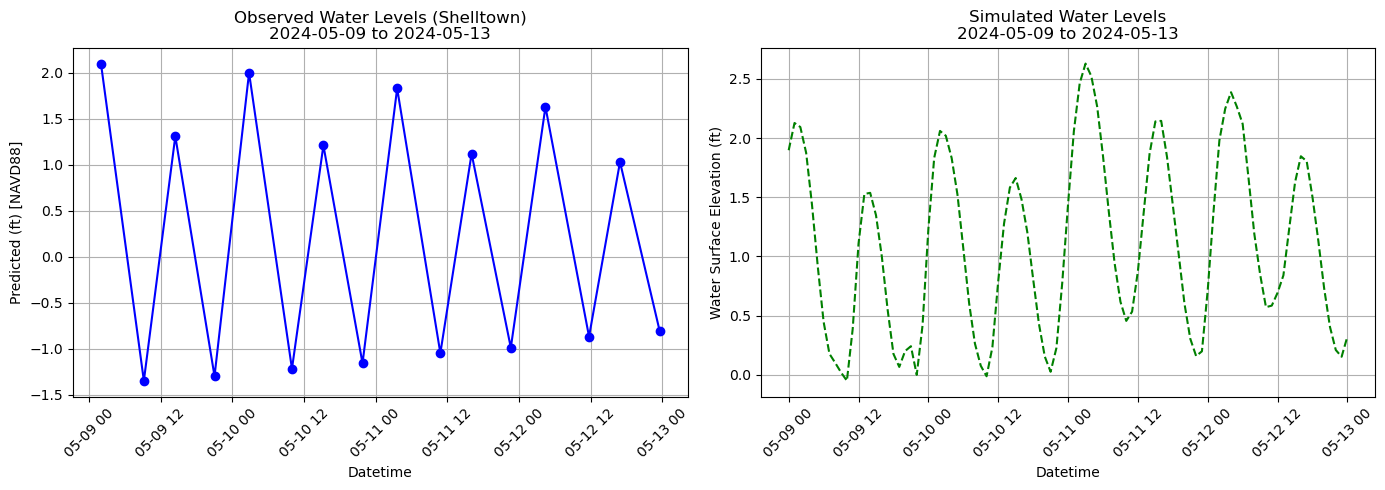

In [ ]:
#Plot close to Shelltown, MD Gauge Data

import pandas as pd
import matplotlib.pyplot as plt

# === Load Excel files ===
file_obs = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\BookShellfinal.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_gage_closeShel.xlsx" #Diffusion Wave Equation Set (fastest) (v5.p79)

df_obs = pd.read_excel(file_obs)
df_sim = pd.read_excel(file_sim)

# === Clean column names ===
df_obs.columns = df_obs.columns.str.strip()
df_sim.columns = df_sim.columns.str.strip()

# === Create datetime columns ===
df_obs['Datetime'] = pd.to_datetime(df_obs['Date'].astype(str) + ' ' + df_obs['Time'].astype(str))
df_sim['Datetime'] = pd.to_datetime(df_sim['Time'])

# === Filter the date range ===
start_date = pd.to_datetime("2024-05-09")
end_date = pd.to_datetime("2024-05-13")

df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

# === Plot side-by-side ===
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=False)

# Observed plot
axes[0].plot(df_obs_filtered['Datetime'], df_obs_filtered['Predicted (ft)(NAV)'],
             color='blue', marker='o')
axes[0].set_title('Observed Water Levels (Shelltown)\n2024-05-09 to 2024-05-13')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Predicted (ft) [NAVD88]')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Simulated plot
axes[1].plot(df_sim_filtered['Datetime'], df_sim_filtered['WSE (feet)'],
             color='green', linestyle='--')
axes[1].set_title('Simulated Water Levels\n2024-05-09 to 2024-05-13')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Water Surface Elevation (ft)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()

#Compare model results and Snow Hill gauge
    
    -Reference cross 31

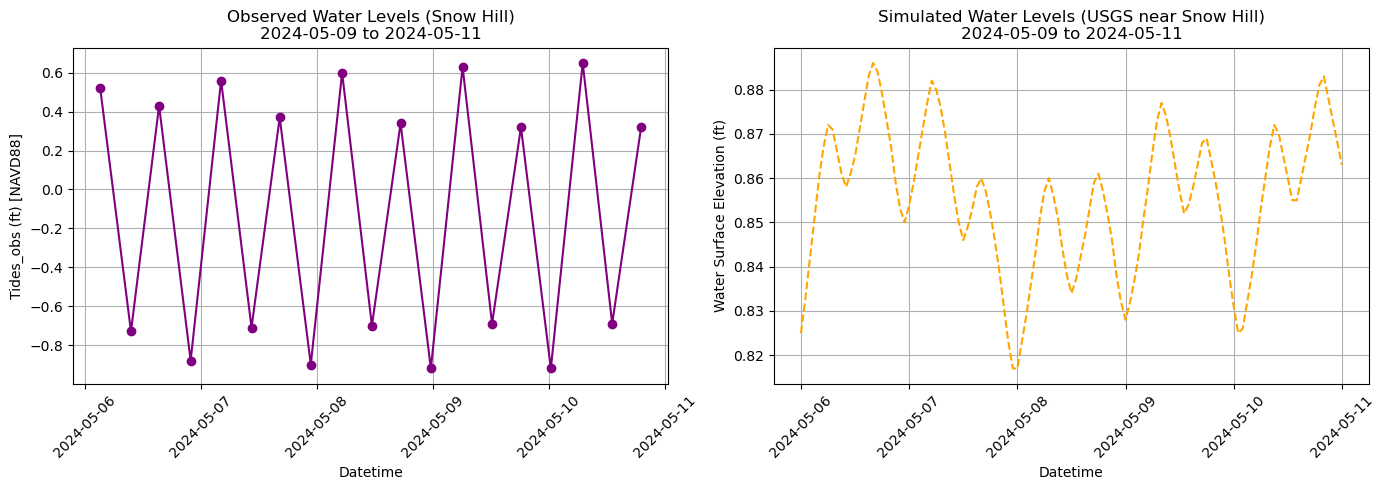

In [14]:
#Plot close to Snow Hill,  Gauge Data (period detail)
import pandas as pd
import matplotlib.pyplot as plt

# === Load Excel files ===
file_obs = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\Book_Snowhill.xlsx"
file_sim = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Depth_2024\USGS_closesnowSEQ.xlsx" #Shallow Water Equations  (v5.p81)

# === Read data ===
df_obs = pd.read_excel(file_obs)
df_sim = pd.read_excel(file_sim)

# === Clean column names ===
df_obs.columns = df_obs.columns.str.strip()
df_sim.columns = df_sim.columns.str.strip()

# === Create datetime columns ===
df_obs['Datetime'] = pd.to_datetime(df_obs['Date'].astype(str) + ' ' + df_obs['Time'].astype(str))
df_sim['Datetime'] = pd.to_datetime(df_sim['Datetime'])

# === Filter date range: May 9–13, 2024 ===
start_date = pd.to_datetime("2024-05-06")
end_date = pd.to_datetime("2024-05-11")

df_obs_filtered = df_obs[(df_obs['Datetime'] >= start_date) & (df_obs['Datetime'] <= end_date)]
df_sim_filtered = df_sim[(df_sim['Datetime'] >= start_date) & (df_sim['Datetime'] <= end_date)]

# === Plot side-by-side ===
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=False)

# Observed
axes[0].plot(df_obs_filtered['Datetime'], df_obs_filtered['Tides_obs (ft)'],
             color='purple', marker='o')
axes[0].set_title('Observed Water Levels (Snow Hill)\n2024-05-09 to 2024-05-11')
axes[0].set_xlabel('Datetime')
axes[0].set_ylabel('Tides_obs (ft) [NAVD88]')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Simulated
axes[1].plot(df_sim_filtered['Datetime'], df_sim_filtered['WSE (feet)'],
             color='orange', linestyle='--')
axes[1].set_title('Simulated Water Levels (USGS near Snow Hill)\n2024-05-09 to 2024-05-11')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Water Surface Elevation (ft)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()